# MATH 4570 Project


In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

from glob import glob

## Data Preparation

In [30]:
labels = pd.read_csv('BrainDataCT/hemorrhage-labels.csv')

# pick rows that we have images for
# types = ['brain_bone_window', 'brain_window', 'max_contrast_window', 'subdural_window']
imageType = 'max_contrast_window'
files = [file.split('/')[-1].split('.')[0] for file in glob(f'BrainDataCT/renders/**/{imageType}/*.jpg', recursive=True)]
labels = labels.loc[labels.Image.isin(files)]
display(labels)

# filter out rows that have multiple labels
labels = labels[labels['epidural'] + labels['intraparenchymal'] + labels['intraventricular'] + labels['subarachnoid'] + labels['subdural'] <= 1]
display(labels)

# take a random sample for local development
labels = labels.sample(5000, random_state = 1)
display(labels)

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf,0,0,0,0,0,0
1,ID_000039fa0,0,0,0,0,0,0
2,ID_00005679d,0,0,0,0,0,0
3,ID_00008ce3c,0,0,0,0,0,0
4,ID_0000950d7,0,0,0,0,0,0
...,...,...,...,...,...,...,...
752755,ID_fffc60817,1,0,1,1,0,0
752769,ID_fffd00949,1,0,0,0,1,0
752783,ID_fffe2edb8,1,0,1,1,0,0
752799,ID_ffff922b9,1,0,0,1,0,0


,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf,0,0,0,0,0,0
1,ID_000039fa0,0,0,0,0,0,0
2,ID_00005679d,0,0,0,0,0,0
3,ID_00008ce3c,0,0,0,0,0,0
4,ID_0000950d7,0,0,0,0,0,0
...,...,...,...,...,...,...,...
752737,ID_fffaebafd,1,0,1,0,0,0
752740,ID_fffb16e96,1,0,0,0,0,1
752769,ID_fffd00949,1,0,0,0,1,0
752799,ID_ffff922b9,1,0,0,1,0,0


,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
120900,ID_29167fe2d,1,0,0,0,0,1
295348,ID_642b8b0e2,1,0,0,0,1,0
204785,ID_4593898a9,1,0,0,0,0,1
726427,ID_f70771536,1,0,0,1,0,0
199255,ID_43abedac6,1,0,0,0,1,0
...,...,...,...,...,...,...,...
642952,ID_da856f276,1,0,0,0,1,0
648956,ID_dc89acbe4,1,0,1,0,0,0
541265,ID_b7b7929f7,1,1,0,0,0,0
27401,ID_094532ebd,1,0,0,0,1,0


In [31]:
labelDict = {
    'normal': 0,
    'epidural': 1,
    'intraparenchymal': 2,
    'intraventricular': 3,
    'subarachnoid': 4,
    'subdural': 5
}

def getLabel(row):
    return next((x for x in labelDict.keys() if x != 'normal' and row[x] == 1), 'normal')

y = labels.apply(lambda row: labelDict.get(getLabel(row)), axis = 1)
np.histogram(y, bins=[0, 1, 2, 3, 4, 5, 6])

(array([ 518,   94,  918,  568,  959, 1943]), array([0, 1, 2, 3, 4, 5, 6]))

In [32]:
def importImages(labels, imageType):
    total = len(labels);
    pixels = 512 * 512
    data = np.zeros([total, pixels])
    for n, file_name in enumerate(labels.Image):
        label = getLabel(labels[labels['Image'] == file_name].iloc[0])
        print(f'importing {n + 1}/{total}', end='\r')
        try:
            path = f'BrainDataCT/renders/{label}/{imageType}/{file_name}.jpg'
            # select the first 512 * 512 pixels
            img = np.mean(mpl.image.imread(path), axis=2).reshape(-1)[:pixels]
            # pad with zeros up to 512 * 512 
            data[n,:] = np.pad(img, (0, pixels - len(img)), 'constant')
        except BaseException as err:
            print(f'\nFailed to import BrainDataCT/renders/{label}/{imageType}/{file_name}.jpg. {err}')
    print('\nDone')
    return data

originalImages = importImages(labels, imageType)

importing 5000/5000
Done


In [33]:
DS = 16             
im_size = int(512 * 512 / DS)
data = np.zeros([len(labels), im_size])
for n, file_name in enumerate(labels.Image):    
    data[n,:] = originalImages[n][::DS]

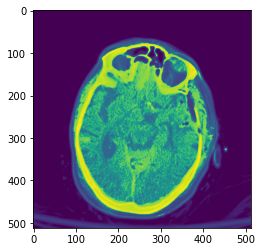

In [34]:
plt.imshow(originalImages[1].reshape(512, 512))

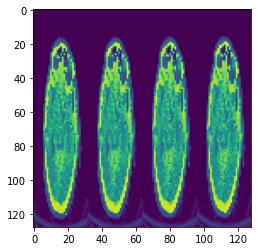

In [35]:
plt.imshow(data[1].reshape(128, 128))

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=1)
input_shape = X_train.shape[1]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4000, 16384) (4000,)
(1000, 16384) (1000,)


## Linear Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', max_iter=1000)
clf.fit(X_train[0:1000],y_train[0:1000])

print("Logistic Regression Score: %.3f"%clf.score(X_test,y_test))

## Artificial Neural Network Model

In [934]:
import tensorflow as tf
from tensorflow import keras

K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
        
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# TODO: Find best model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[input_shape]),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dense(250, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(6, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 500)               8192500   
                                                                 
 dense_1 (Dense)             (None, 250)               125250    
                                                                 
 dense_2 (Dense)             (None, 100)               25100     
                                                                 
 dense_3 (Dense)             (None, 50)                5050      
                                                                 
 dense_4 (Dense)             (None, 6)                 306       
                                                                 
Total params: 8,348,206
Trainable params: 8,348,206
Non-

In [935]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-4),
              metrics=["accuracy"])

### Training the Neural Network model

In [936]:
expon_lr = ExponentialLearningRate(factor=1.04)
history = model.fit(X_train, y_train, 
                    epochs=1,
                    validation_data=(X_test, y_test),
                    callbacks=[expon_lr])

125/125 [==============================] - 4s 25ms/step - loss: 1475.1012 - accuracy: 0.2558 - val_loss: 1.7686 - val_accuracy: 0.4090


Text(0, 0.5, 'Loss')

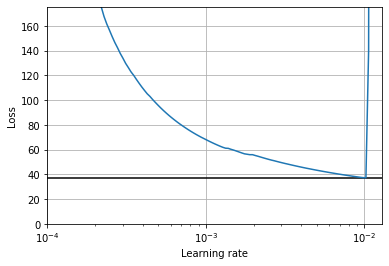

In [937]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [938]:
min(expon_lr.losses)

37.35354995727539

In [939]:
expon_lr.rates[np.argmin(expon_lr.losses)]

0.010231329

In [942]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# TODO: Find the best model

# Result with 2e-4: loss: 1.3220 - accuracy: 0.4645 - val_loss: 1.5019 - val_accuracy: 0.4300
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[input_shape]),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dense(250, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(6, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=2e-4),
              metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=8, epochs=30,
                    validation_data=(X_test, y_test))

Epoch 1/30
500/500 [==============================] - 9s 17ms/step - loss: 43.0214 - accuracy: 0.3495 - val_loss: 1.5458 - val_accuracy: 0.4110
Epoch 2/30
500/500 [==============================] - 8s 15ms/step - loss: 1.6159 - accuracy: 0.3765 - val_loss: 1.5813 - val_accuracy: 0.4110
Epoch 3/30
500/500 [==============================] - 7s 15ms/step - loss: 1.5673 - accuracy: 0.3835 - val_loss: 1.5177 - val_accuracy: 0.4130
Epoch 4/30
500/500 [==============================] - 8s 15ms/step - loss: 1.5565 - accuracy: 0.3877 - val_loss: 1.5109 - val_accuracy: 0.4150
Epoch 5/30
500/500 [==============================] - 8s 16ms/step - loss: 1.5357 - accuracy: 0.3893 - val_loss: 1.5098 - val_accuracy: 0.4140
Epoch 6/30
500/500 [==============================] - 9s 17ms/step - loss: 1.5236 - accuracy: 0.3945 - val_loss: 1.4928 - val_accuracy: 0.4150
Epoch 7/30
500/500 [==============================] - 7s 14ms/step - loss: 1.5194 - accuracy: 0.3915 - val_loss: 1.5092 - val_accuracy: 0.408

In [904]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 1s 9ms/step - loss: 1.5019 - accuracy: 0.4300


[1.5019190311431885, 0.4300000071525574]

## Convoluted Neural Network Model

In [ ]:
## We have to add an extra dimension to allow for the multiple images we will be creating
X_train = X_train.reshape(-1, input_shape, 1)
X_test = X_test.reshape(-1, input_shape, 1)

Y_train = np_utils.to_categorical(y_train, len(labelDict.keys()))
Y_test = np_utils.to_categorical(y_test, len(labelDict.keys()))

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()
model.add(Conv2D(32, (7, 7),
                 padding='valid',
                 input_shape=(input_shape,1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=len(labelDict.keys()), activation='softmax'))
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
epochs = 5
history = model.fit(X_train, 
                    Y_train, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=1,
                    validation_data=(X_test, Y_test))